<a href="https://colab.research.google.com/github/marybarbiebarrion/ComputerVision-FinalCase/blob/main/BARRION_DEGUZMAN_FINAL_CASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BARRION, Mary Barbie & DE GUZMAN, Adrian Gil D.**

# **SEGMENTATION**

## SEGMENTATION MODEL

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)
        mask = np.where(mask > 127, 1, 0).astype(np.float32)

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((256, 256))(Image.fromarray(mask))
            mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

!git clone https://github.com/marybarbiebarrion/PyUnet.git

image_dir = '/content/PyUnet/sessile-main-Kvasir-SEG/images'
mask_dir = '/content/PyUnet/sessile-main-Kvasir-SEG/masks'

dataset = KvasirSegDataset(image_dir, mask_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

sample_images, sample_masks = next(iter(train_loader))
print(f"Train Batch - Image Shape: {sample_images.shape}, Mask Shape: {sample_masks.shape}")

Cloning into 'PyUnet'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (309/309), done.
remote: Total 400 (delta 89), reused 397 (delta 89), pack-reused 0 (from 0)
Receiving objects: 100% (400/400), 12.43 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Train Batch - Image Shape: torch.Size([8, 3, 256, 256]), Mask Shape: torch.Size([8, 1, 256, 256])


In [2]:
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv(x)

class ModifiedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ModifiedUNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downs.append(DoubleConv(in_channels, 64))
        self.downs.append(DoubleConv(64, 128))
        self.downs.append(DoubleConv(128, 256))
        self.downs.append(DoubleConv(256, 512))
        self.downs.append(DoubleConv(512, 1024))

        self.bottleneck = DoubleConv(1024, 2048)

        self.ups.append(nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2))
        self.ups.append(DoubleConv(2048, 1024))
        self.ups.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.ups.append(DoubleConv(1024, 512))
        self.ups.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.ups.append(DoubleConv(512, 256))
        self.ups.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.ups.append(DoubleConv(256, 128))
        self.ups.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.ups.append(DoubleConv(128, 64))

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedUNet(in_channels=3, out_channels=1).to(device)

# # Print the model to check the architecture
# print(model)

In [3]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedUNet(in_channels=3, out_channels=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
    for batch_idx, (images, masks) in enumerate(train_loader_tqdm):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        masks = masks.squeeze(1).long()

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}")
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            masks = masks.squeeze(1).long()
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

print("Training complete!")

torch.save(model.state_dict(), 'modified_unet_model.pth')

Epoch 1/10


Training Epoch 1: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s, loss=0.756]


Epoch [1/10], Loss: 0.8039


Validation Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Validation Loss: 0.8273
Epoch 2/10


Training Epoch 2: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s, loss=0.792]


Epoch [2/10], Loss: 0.7745


Validation Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


Validation Loss: 0.8058
Epoch 3/10


Training Epoch 3: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s, loss=0.771]


Epoch [3/10], Loss: 0.7620


Validation Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


Validation Loss: 0.7759
Epoch 4/10


Training Epoch 4: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s, loss=0.735]


Epoch [4/10], Loss: 0.7511


Validation Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


Validation Loss: 0.7712
Epoch 5/10


Training Epoch 5: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s, loss=0.757]


Epoch [5/10], Loss: 0.7452


Validation Epoch 5: 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


Validation Loss: 0.7799
Epoch 6/10


Training Epoch 6: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s, loss=0.73]


Epoch [6/10], Loss: 0.7336


Validation Epoch 6: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Validation Loss: 0.8497
Epoch 7/10


Training Epoch 7: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s, loss=0.744]


Epoch [7/10], Loss: 0.7220


Validation Epoch 7: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Validation Loss: 2.2197
Epoch 8/10


Training Epoch 8: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s, loss=0.687]


Epoch [8/10], Loss: 0.7190


Validation Epoch 8: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Validation Loss: 0.7576
Epoch 9/10


Training Epoch 9: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s, loss=0.714]


Epoch [9/10], Loss: 0.7077


Validation Epoch 9: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Validation Loss: 0.7555
Epoch 10/10


Training Epoch 10: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s, loss=0.722]


Epoch [10/10], Loss: 0.6954


Validation Epoch 10: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Validation Loss: 0.7338
Training complete!


In [4]:
def compute_iou(pred, target, num_classes=2):

    pred = torch.argmax(pred, dim=1)

    intersection = (pred * target).sum((1, 2)).float()
    union = (pred + target).clamp(0, 1).sum((1, 2)).float()

    iou = intersection / (union + 1e-6)
    return iou.mean().item()

model.eval()
iou_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        masks = masks.squeeze(1).long()

        iou_scores.append(compute_iou(outputs, masks))

mean_iou = sum(iou_scores) / len(iou_scores)
print(f"Mean IoU Score: {mean_iou:.4f}")

Mean IoU Score: 0.1451


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, num_samples * 3))

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break  # Stop after visualizing num_samples

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)  # Forward pass

            # Convert logits to class labels
            pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (B, H, W)
            true_masks = masks.cpu().numpy().squeeze(1)  # Shape: (B, H, W)
            images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (B, H, W, C)

            # Create overlays
            overlay_gt = np.zeros_like(images[0])
            overlay_pred = np.zeros_like(images[0])
            overlap = np.zeros_like(images[0])
            combined_overlay = np.zeros_like(images[0])

            # Ground truth in red, prediction in green, overlap in yellow
            overlay_gt[true_masks[0] == 1] = [1, 0, 0]  # Red for ground truth
            overlay_pred[pred_masks[0] == 1] = [0, 1, 0]  # Green for prediction
            overlap[(true_masks[0] == 1) & (pred_masks[0] == 1)] = [1, 1, 0]  # Yellow for overlap

            # Combine all overlays: red (GT) + green (prediction) + yellow (overlap)
            combined_overlay = np.maximum(overlay_gt, np.maximum(overlay_pred, overlap))

            # Plot results
            axes[i, 0].imshow(images[0])  # Show original image
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(images[0])  # Show original image with red overlay for ground truth
            axes[i, 1].imshow(overlay_gt, alpha=0.5)  # Overlay ground truth in red
            axes[i, 1].set_title("Ground Truth (Red)")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(images[0])  # Show original image with green overlay for prediction
            axes[i, 2].imshow(overlay_pred, alpha=0.5)  # Overlay prediction in green
            axes[i, 2].set_title("Prediction (Green)")
            axes[i, 2].axis("off")

            axes[i, 3].imshow(images[0])  # Show original image with yellow overlay for overlap
            axes[i, 3].imshow(overlap, alpha=0.5)  # Overlay overlap in yellow
            axes[i, 3].set_title("Overlap (Yellow)")
            axes[i, 3].axis("off")

            axes[i, 4].imshow(images[0])  # Show original image with combined overlay
            axes[i, 4].imshow(combined_overlay, alpha=0.5)  # Combined overlay (GT, prediction, overlap)
            axes[i, 4].set_title("Combined Masks")
            axes[i, 4].axis("off")

        # Add the legend
        plt.legend(['Ground Truth (Red)', 'Prediction (Green)', 'Overlap (Yellow)'], loc='upper left')

    plt.tight_layout()
    plt.show()


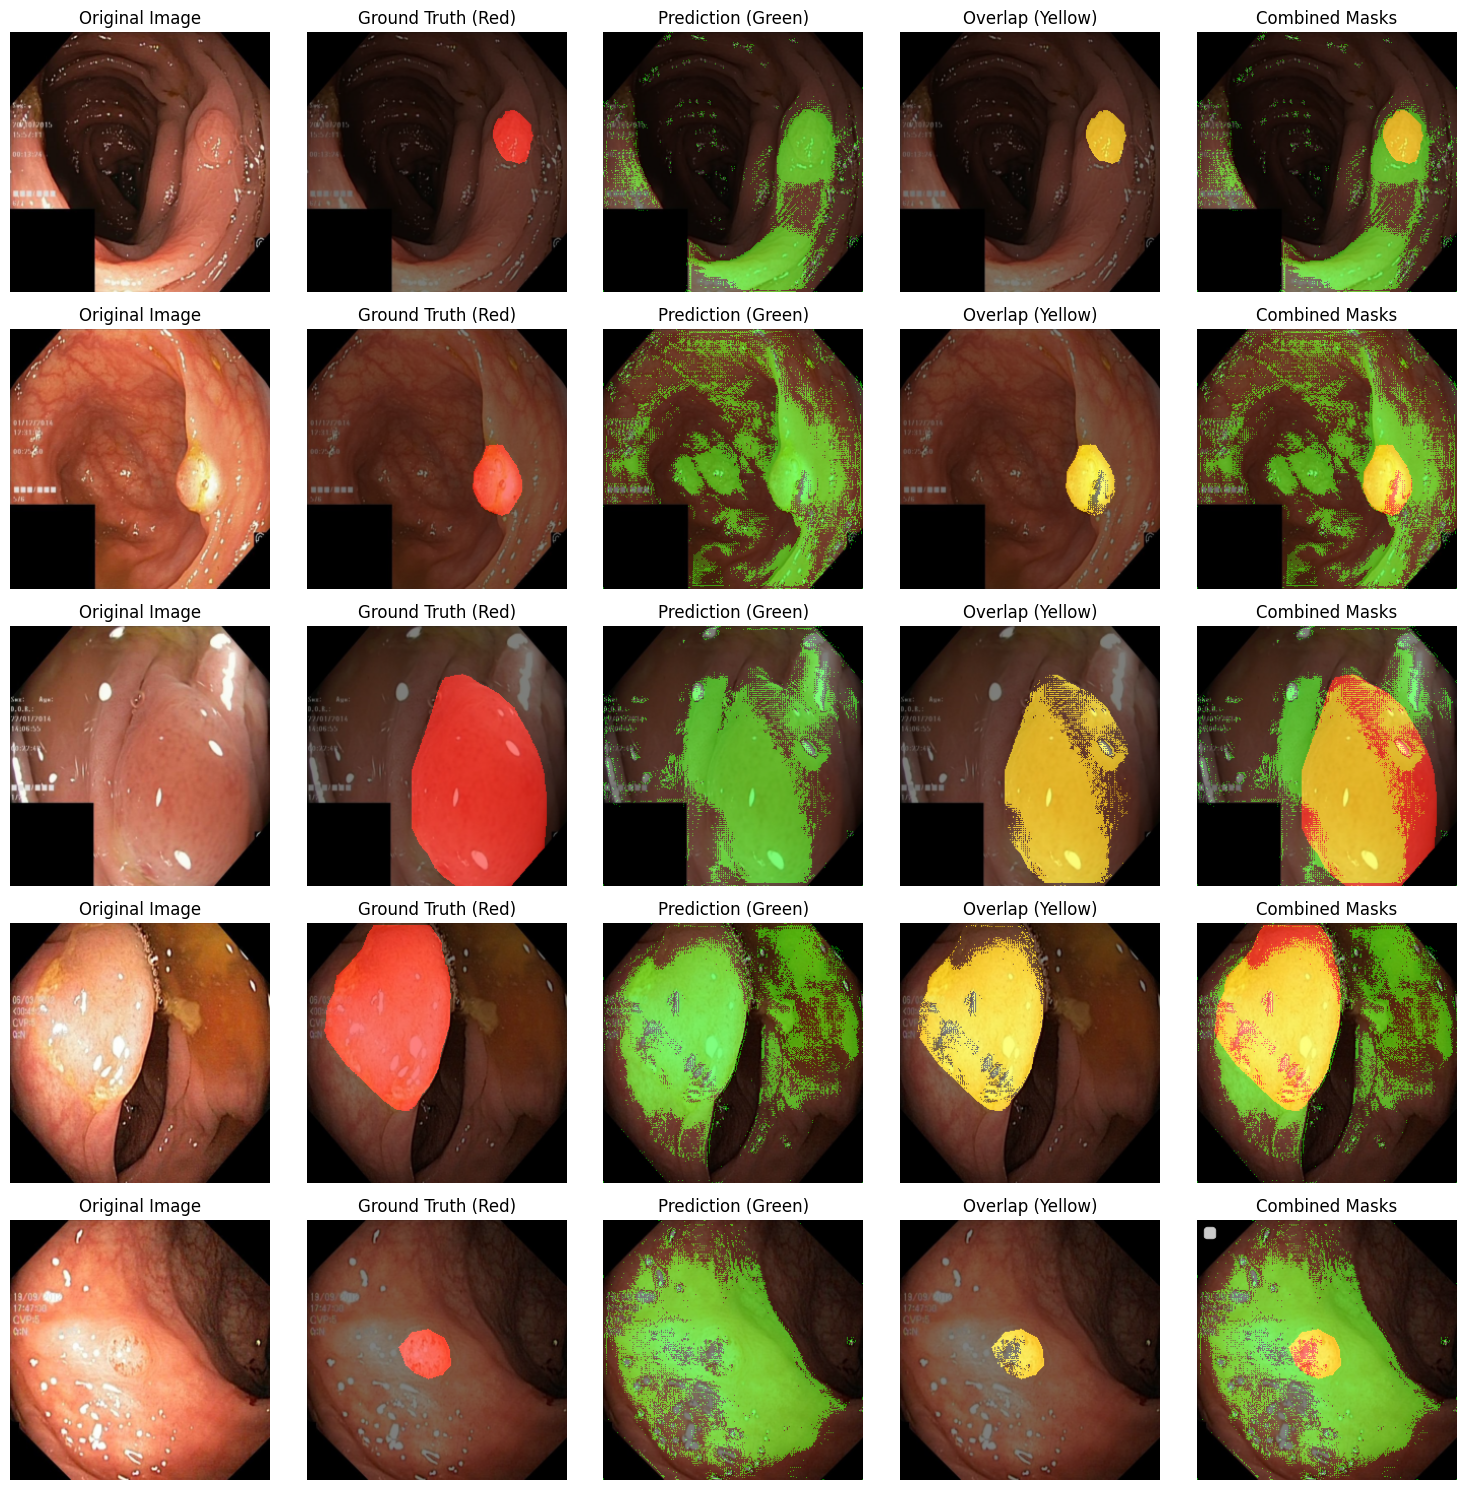

In [11]:
visualize_predictions(model, val_loader, device)

## GRADCAM INSTALLATION FOR SEGMENTATION

In [7]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.8 MB/s 

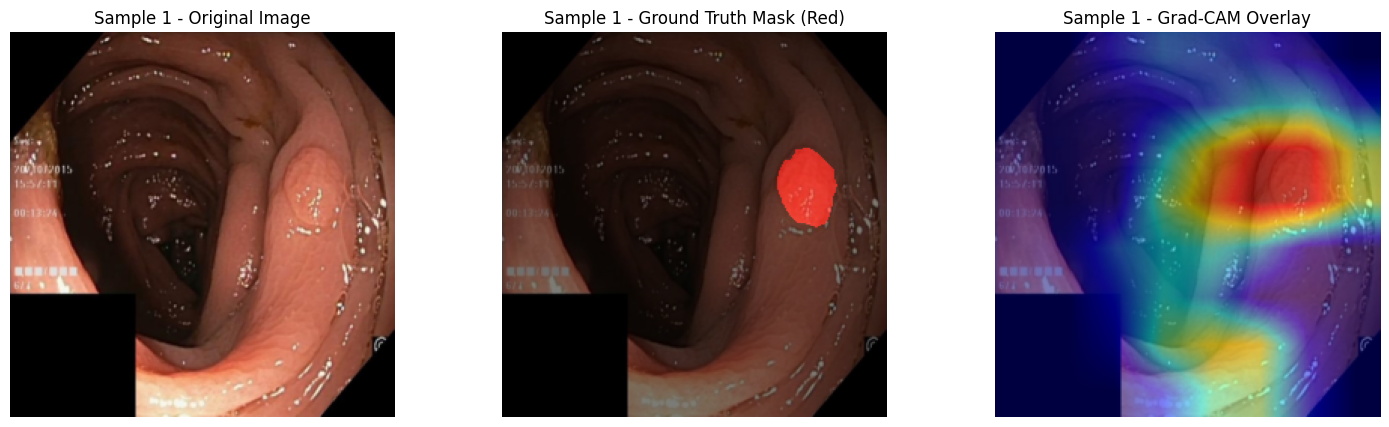

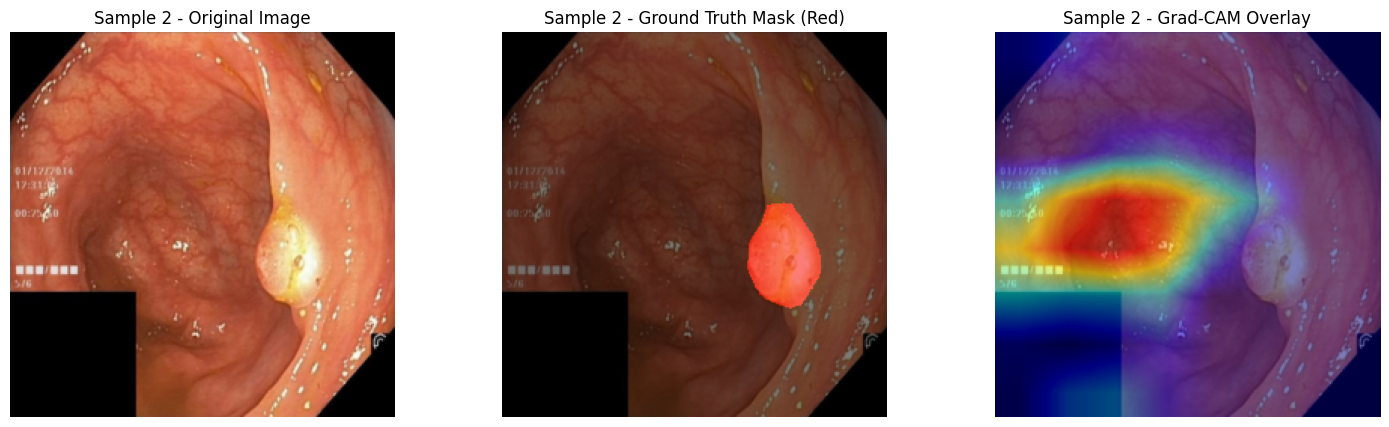

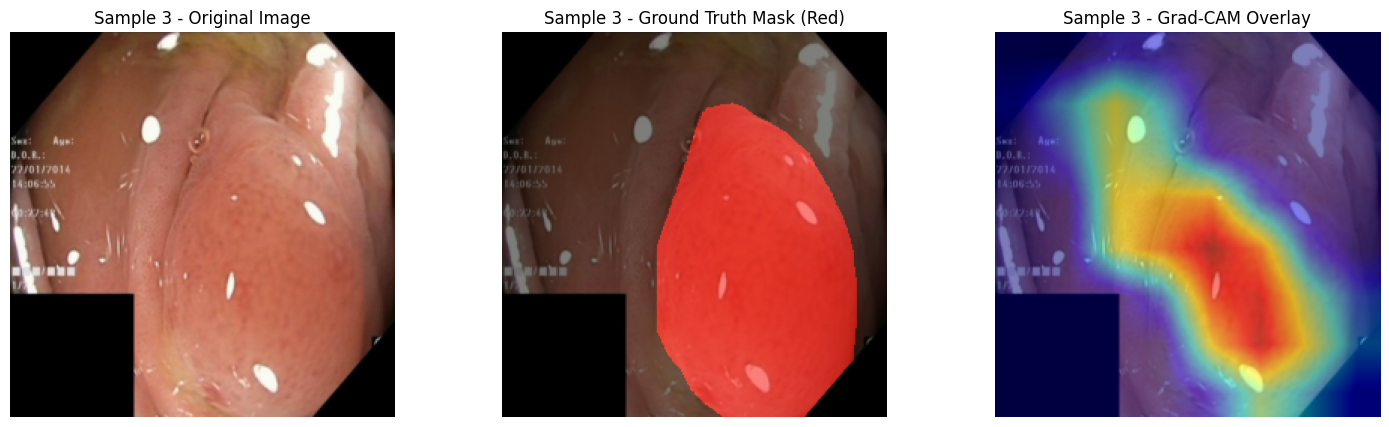

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define target layer for GradCAM (bottleneck conv output)
target_layer = model.bottleneck.conv[-1]  # Last ReLU in bottleneck

# Use grad-cam with SemanticSegmentationTarget
cam = GradCAM(model=model, target_layers=[target_layer])

# Number of samples to visualize
num_samples_to_visualize = 3

# Iterate through the validation loader to get samples
for i, (images, masks) in enumerate(val_loader):
    if i >= num_samples_to_visualize:
        break  # Stop after visualizing the desired number of samples

    images = images.to(device)
    masks = masks.to(device)

    # Select the current sample in the batch
    input_tensor = images[0].unsqueeze(0)
    target_mask_tensor = masks[0].unsqueeze(0)

    # Create target for class 1 (segmentation foreground)
    # Convert the target mask tensor to a numpy array
    targets = [SemanticSegmentationTarget(category=1, mask=target_mask_tensor.cpu().numpy())]

    # Generate Grad-CAM
    # Ensure the input_tensor is passed through the cam, even if targets are provided
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # Select the CAM for the first image in the batch (since we passed a single image)
    grayscale_cam = grayscale_cam[0]


    # Convert input image to numpy for visualization
    input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    # Normalize the image for display
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min()) if input_image.max() > input_image.min() else input_image


    # Create an overlay for the ground truth mask in red (for visualization)
    overlay_gt = np.zeros_like(input_image)
    # Fix: Squeeze the boolean mask to match the shape of overlay_gt
    overlay_gt[(target_mask_tensor.squeeze(0).squeeze(0).cpu().numpy() == 1)] = [1, 0, 0]  # Red for ground truth

    # Show Grad-CAM overlay
    cam_image = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

    # Plot results with three columns
    plt.figure(figsize=(18, 5))

    # First subplot: Original Image
    plt.subplot(1, 3, 1)
    plt.title(f"Sample {i+1} - Original Image")
    plt.imshow(input_image)
    plt.axis('off')

    # Second subplot: Original Image with Ground Truth Mask overlayed in red
    plt.subplot(1, 3, 2)
    plt.title(f"Sample {i+1} - Ground Truth Mask (Red)")
    plt.imshow(input_image)
    plt.imshow(overlay_gt, alpha=0.5)  # Overlay ground truth in red
    plt.axis('off')

    # Third subplot: Grad-CAM Overlay
    plt.subplot(1, 3, 3)
    plt.title(f"Sample {i+1} - Grad-CAM Overlay")
    plt.imshow(cam_image)
    plt.axis('off')

    plt.show()

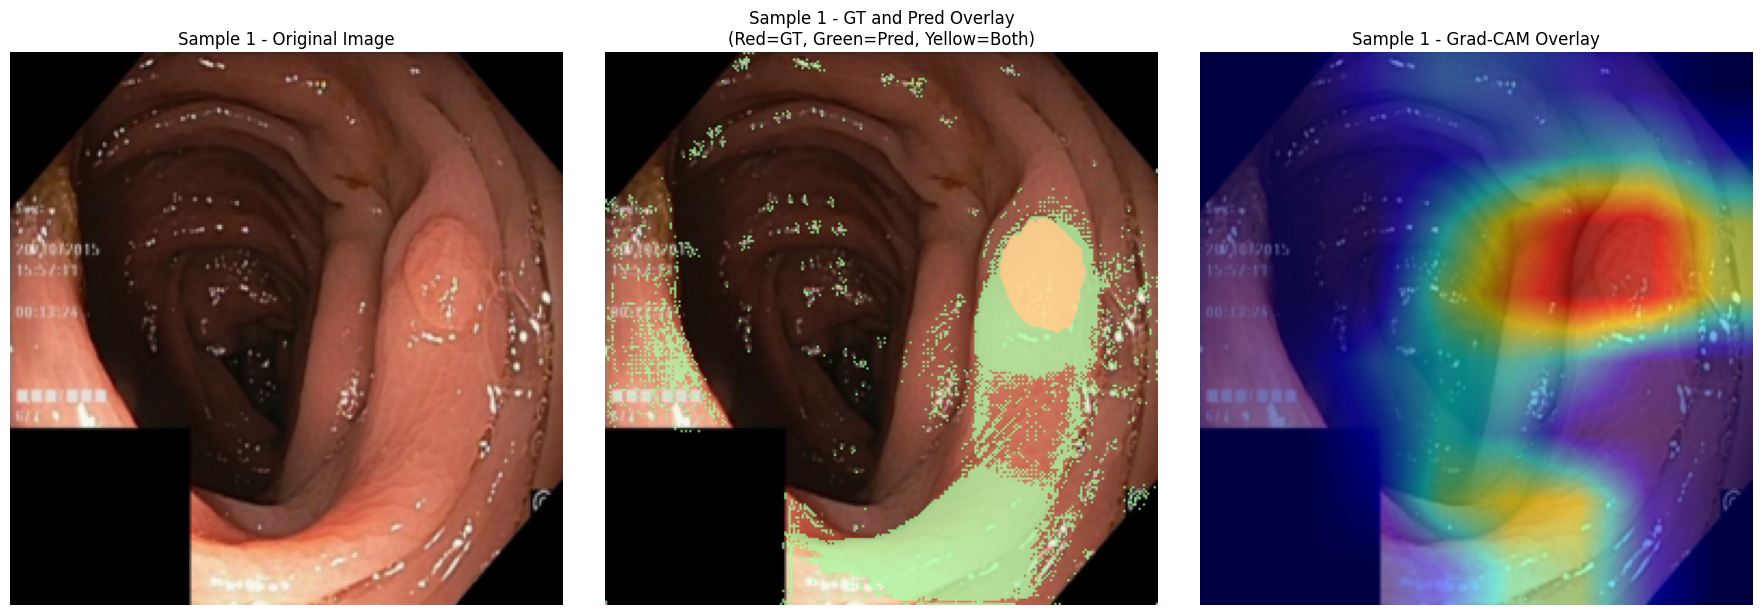

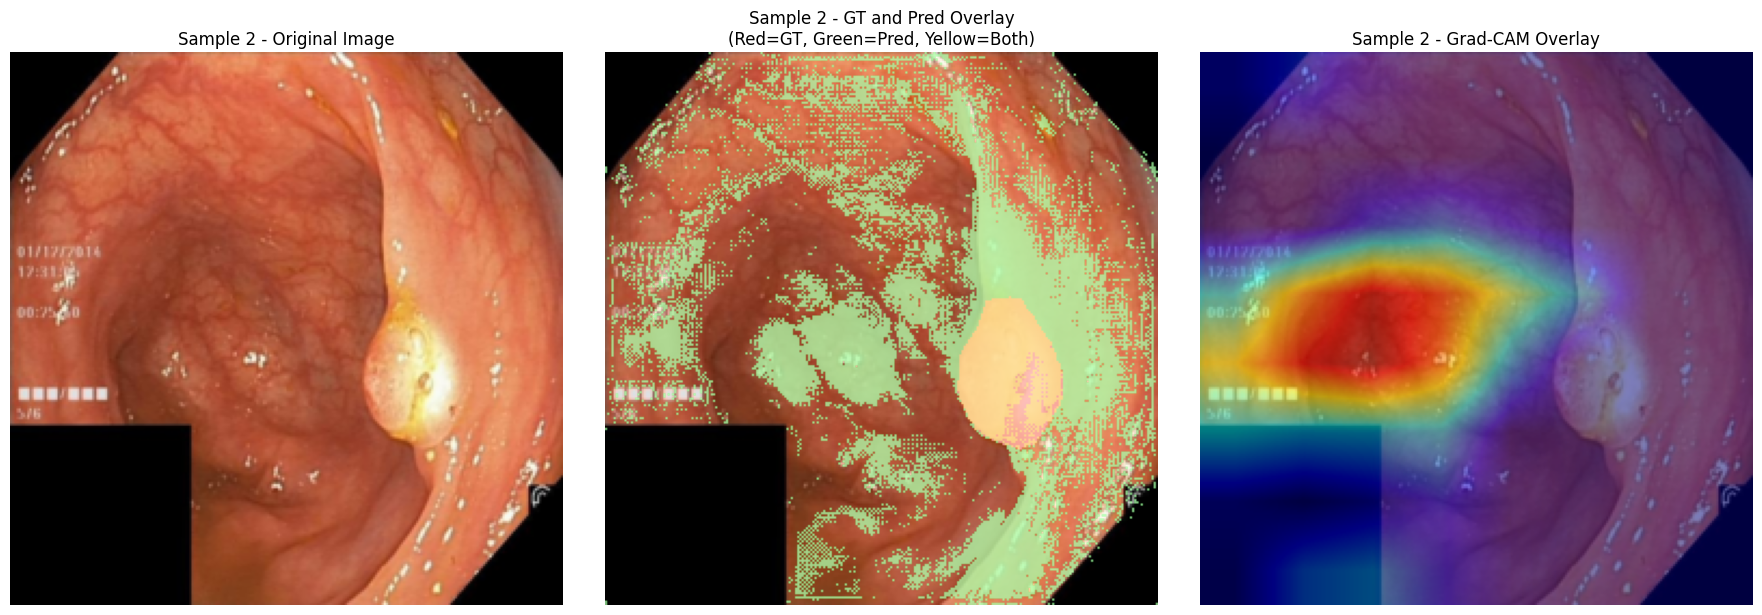

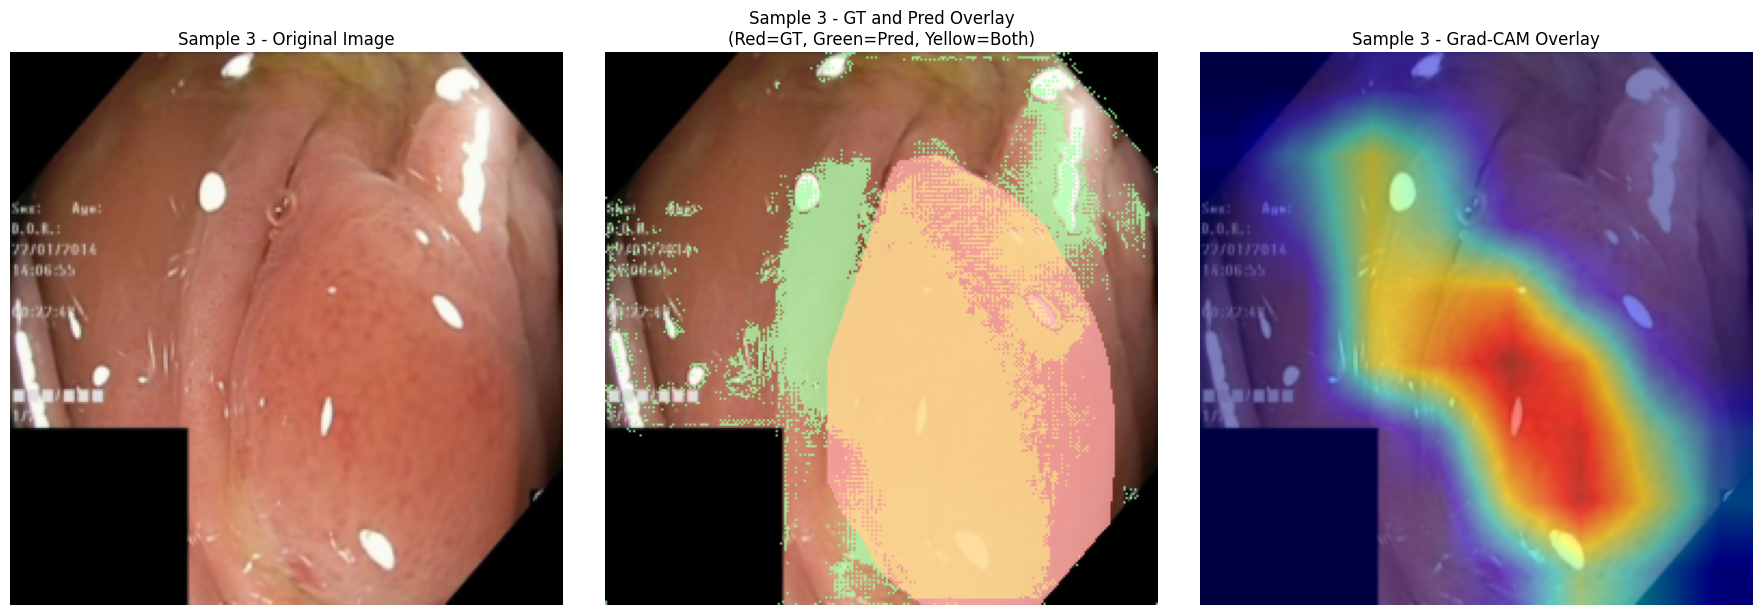

In [9]:
# Define target layer for GradCAM (bottleneck conv output)
target_layer = model.bottleneck.conv[-1]  # Last ReLU in bottleneck

# Use grad-cam with SemanticSegmentationTarget
cam = GradCAM(model=model, target_layers=[target_layer])

# Number of samples to visualize
num_samples_to_visualize = 3

# Iterate through the validation loader to get samples
for i, (images, masks) in enumerate(val_loader):
    if i >= num_samples_to_visualize:
        break  # Stop after visualizing the desired number of samples

    images, masks = images.to(device), masks.to(device)

    # Select the current sample in the batch
    input_tensor = images[0].unsqueeze(0)
    target_mask_tensor = masks[0].unsqueeze(0)

    # Create target for class 1 (segmentation foreground)
    # Convert the target mask tensor to a numpy array
    targets = [SemanticSegmentationTarget(category=1, mask=target_mask_tensor.cpu().numpy())]

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # Single image cam

    # Convert input image to numpy for visualization
    input_image_np = input_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    # Normalize the image for display
    input_image_np_display = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min()) if input_image_np.max() > input_image_np.min() else input_image_np

    # Generate Grad-CAM overlay image
    cam_image = show_cam_on_image(input_image_np_display, grayscale_cam, use_rgb=True)

    # Convert ground truth mask to numpy for visualization
    true_mask_np = masks[0].squeeze(0).cpu().numpy()

    # Get model prediction and convert to numpy
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask_tensor = torch.argmax(output, dim=1).squeeze(0)
        pred_mask_np = pred_mask_tensor.cpu().numpy()

    # Create overlay image for Ground Truth and Predicted Mask
    overlay_image = input_image_np_display.copy()
    overlay_image = np.concatenate([overlay_image, np.ones((*overlay_image.shape[:2], 1))], axis=-1) # Add alpha channel
    overlay_image = overlay_image.astype(np.float32) # Ensure float32 for calculations

    # Overlay Ground Truth (Red)
    overlay_image[true_mask_np == 1, :3] = overlay_image[true_mask_np == 1, :3] * 0.5 + np.array([1, 0, 0]) * 0.5
    overlay_image[true_mask_np == 1, 3] = 0.5

    # Overlay Predicted Mask (Green)
    # Only add predicted mask where ground truth is not 1 to avoid overwriting
    predicted_only_mask = (pred_mask_np == 1) & (true_mask_np != 1)
    overlay_image[predicted_only_mask, :3] = overlay_image[predicted_only_mask, :3] * 0.5 + np.array([0, 1, 0]) * 0.5
    overlay_image[predicted_only_mask, 3] = 0.5

    # Overlay areas where both are 1 (Yellow/Orange)
    both_mask = (pred_mask_np == 1) & (true_mask_np == 1)
    overlay_image[both_mask, :3] = overlay_image[both_mask, :3] * 0.5 + np.array([1, 1, 0]) * 0.5 # Yellow
    overlay_image[both_mask, 3] = 0.5

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Increase figure size for three plots

    # Plot Original Image
    axes[0].imshow(input_image_np_display)
    axes[0].set_title(f"Sample {i+1} - Original Image")
    axes[0].axis('off')

    # Plot Ground Truth and Predicted Mask Overlay
    axes[1].imshow(overlay_image)
    axes[1].set_title(f"Sample {i+1} - GT and Pred Overlay\n(Red=GT, Green=Pred, Yellow=Both)")
    axes[1].axis('off')

    # Plot Grad-CAM Overlay
    axes[2].imshow(cam_image)
    axes[2].set_title(f"Sample {i+1} - Grad-CAM Overlay")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()